## Telco Customer Churn prediction

In [1]:
# ---Imports
import os, sys, json, math
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
     classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay, PrecisionRecallDisplay
)
import matplotlib.pyplot as plt

In [ ]:
#data_path = os.path.join(data, 'Telco-Customer-Churn.csv')

### loading the data

In [2]:
# ----- Load CSV with robust path handling
import os
import pandas as pd

CANDIDATE_PATHS = [
    "../data/Telco-Customer-Churn.csv",
    "./Telco-Customer-Churn.csv",
    "/mnt/data/Telco-Customer-Churn.csv"
]

for p in CANDIDATE_PATHS:
    if os.path.exists(p):
        data_path = p
        break
else:
    raise FileNotFoundError(f"Could not find Telco-Customer-Churn.csv in any of: {CANDIDATE_PATHS}")

data = pd.read_csv(data_path)
print(f"Loaded data from: {data_path} -> shape={data.shape}")


Loaded data from: ../data/Telco-Customer-Churn.csv -> shape=(7043, 21)


In [3]:
data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# ---shape of data
data.shape

(7043, 21)

## ---Basic Data Cleaning & Quick Sanity checks

In [5]:
# --create a copy of the data
df = data.copy()

In [6]:
# -- dropping unnecessary columns
if 'customerID' in df.columns:
    df.drop(columns=['customerID'], inplace=True)

In [7]:
# --convert target columns to binary
assert 'Churn' in df.columns, 'Expected a "Churn" column'

df['Churn'] = df['Churn'].map({'No': 0, 'Yes': 1}).astype(int)


In [8]:
# --TotalCharges columns
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

    # Fill numeric NaNs with median
    df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())



In [9]:
# -- identify features and dtypes
y = df['Churn']
X = df.drop(columns=['Churn'])


numericals_cols = X.select_dtypes(include=['number']).columns.tolist()

categorical_cols = X.select_dtypes(exclude=['number']).columns.tolist()

In [10]:
# -- split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size = 0.2,
    stratify = y, 
    random_state = 42
)

In [11]:
X_train.shape, X_test.shape

((5634, 19), (1409, 19))

## Prepprocessing

In [12]:
# preprocessing: scale numeric, one-hot-encode categorical columns
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(with_mean=False), numericals_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_cols)
    ],
    remainder='drop'
)

In [13]:
# Inspect class balance and dtypes
print("Target distribution (Churn):")
print(y.value_counts(normalize=True).rename({0:'No',1:'Yes'}))
print("\nNumeric columns:", numericals_cols)
print("Categorical columns:", categorical_cols)


Target distribution (Churn):
Churn
No     0.73463
Yes    0.26537
Name: proportion, dtype: float64

Numeric columns: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical columns: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


## Base Models

In [14]:
# Model A : Logistic Regression (with class_weight for imbalance)
logreg_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", LogisticRegression(max_iter=1000, solver='liblinear', class_weight='balanced'))
])

In [15]:
# Model B : RandomForest
rf_clf = Pipeline(steps=[
    ("preprocess", preprocess),
    ("clf", RandomForestClassifier(n_estimators=300, random_state=42, class_weight='balanced'))
])

In [16]:
# fit base models
logreg_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  StandardScaler(with_mean=False),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('clf',
                 LogisticRegression(class_weight='balanced', max_iter=1000,
                                    solver='liblinear'))])

In [17]:
rf_clf.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num',
                                                  StandardScaler(with_mean=False),
                                                  ['SeniorCitizen', 'tenure',
                                                   'MonthlyCharges',
                                                   'TotalCharges']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['gender', 'Partner',
                                                   'Dependents', 'PhoneService',
                                                   'MultipleLines',
                                                   'InternetService',
                                                   'OnlineSecurity',
                                                   'OnlineBackup',
                                                   'DeviceProtection',
                                                   'TechSupport', 'StreamingTV',
                                                   'StreamingMovies',
                                                   'Contract',
                                                   'PaperlessBilling',
                                                   'PaymentMethod'])])),
                ('clf',
                 RandomForestClassifier(class_weight='balanced',
                                        n_estimators=300, random_state=42))])

## Evaluate base models

In [18]:
from sklearn.metrics import ConfusionMatrixDisplay

def evaluate(model, X_test, y_test, title='Model'):
    y_pred = model.predict(X_test)
    # Use probabilities for ROC/PR curves
    if hasattr(model, "predict_proba"):
        y_proba = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        # scale to [0,1] for metrics expecting probabilities
        from sklearn.preprocessing import MinMaxScaler
        y_scores = model.decision_function(X_test).reshape(-1, 1)
        y_proba = MinMaxScaler().fit_transform(y_scores).ravel()
    else:
        # fall back to predictions
        y_proba = y_pred.astype(float)

    print(f"=== {title} ===")
    try:
        auc = roc_auc_score(y_test, y_proba)
        print("ROC-AUC:", round(auc, 4))
    except Exception as e:
        print("ROC-AUC: N/A", e)
    print(classification_report(y_true=y_test, y_pred=y_pred, digits=3))

    # Confusion matrix (plot)
    disp = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, normalize=None)
    plt.title(f"Confusion Matrix - {title}")
    plt.tight_layout()
    plt.show()

    # ROC curve (use probabilities)
    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title(f"ROC Curve - {title}")
    plt.tight_layout()
    plt.show()

    # Precision-Recall curve (use probabilities)
    PrecisionRecallDisplay.from_predictions(y_test, y_proba)
    plt.title(f"Precision-Recall - {title}")
    plt.tight_layout()
    plt.show()


=== Logistic Regression ===
ROC-AUC: 0.8415
              precision    recall  f1-score   support

           0      0.902     0.722     0.802      1035
           1      0.504     0.783     0.614       374

    accuracy                          0.738      1409
   macro avg      0.703     0.753     0.708      1409
weighted avg      0.797     0.738     0.752      1409



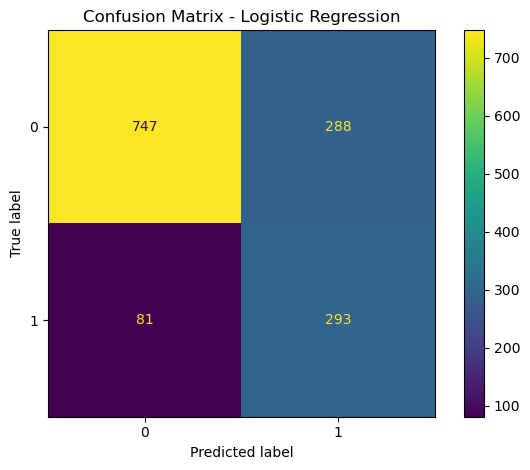

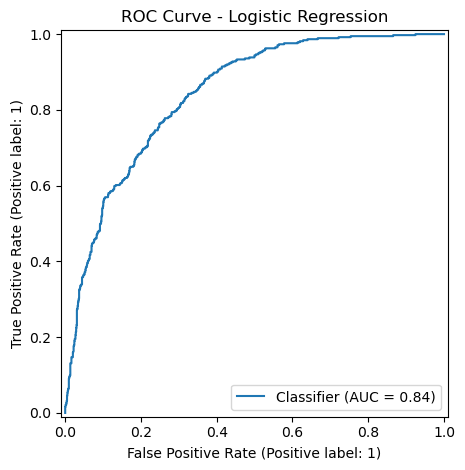

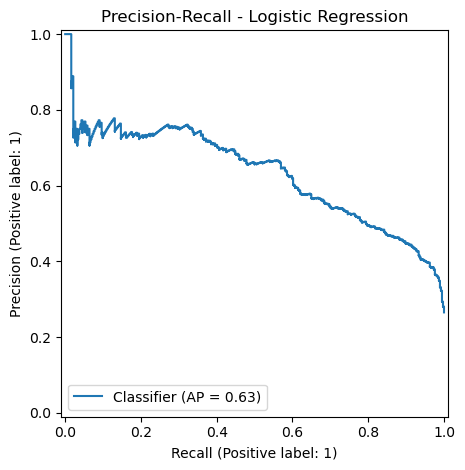

In [19]:
# logistic regression
evaluate(logreg_clf, X_test=X_test, y_test=y_test, title = 'Logistic Regression')

=== Random Forest Classifier ===
ROC-AUC: 0.8219
              precision    recall  f1-score   support

           0      0.824     0.894     0.857      1035
           1      0.615     0.471     0.533       374

    accuracy                          0.781      1409
   macro avg      0.720     0.682     0.695      1409
weighted avg      0.768     0.781     0.771      1409



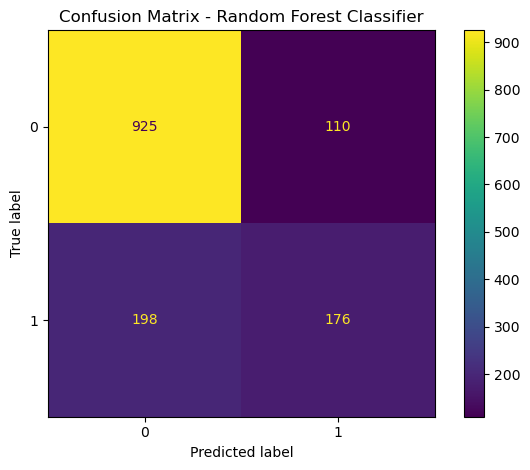

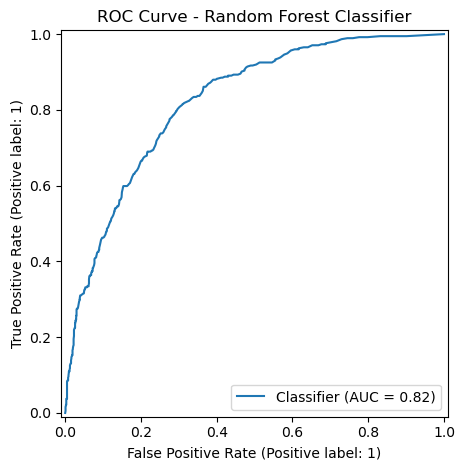

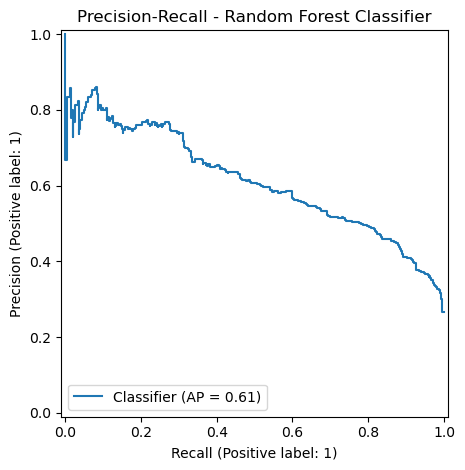

In [20]:
# evaluate random forest
evaluate(rf_clf, X_test=X_test, y_test=y_test, title = 'Random Forest Classifier')

In [21]:
y_test.value_counts()

Churn
0    1035
1     374
Name: count, dtype: int64